# Turbofan engine degradation: train models

# Import modules

In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# tools for this dev
import downloadDataset

# AWS tools
import boto3
import sagemaker

# Load dataset

The dataset can be downloaded by running the script ``downloadDataset.py``. Here, we run the main function of this script to download and prepare the dataset.

In [2]:
# user parameters
dataDir = '/home/ubuntu/datasets/Turbofan engine degradation simulation'
overwrite = True

# download and prepare
downloadDataset.main(dataDir,overwrite)

remove existing taget directory "/home/ubuntu/datasets/Turbofan engine degradation simulation"


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/urllib3/connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


reading and processing file train_FD001.txt
reading and processing file train_FD002.txt
reading and processing file train_FD003.txt
reading and processing file train_FD004.txt
reading and processing file test_FD001.txt
reading and processing file test_FD002.txt
reading and processing file test_FD003.txt
reading and processing file test_FD004.txt
writing assembled dataset to "/home/ubuntu/datasets/Turbofan engine degradation simulation/assembledDataset.csv"


In [3]:
# read the dataset
dataFile = 'assembledDataset.csv'
dset = pd.read_csv(os.path.join(dataDir,dataFile))
dset.head()

,id,cycle,setting1,setting2,setting3,s1,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,s5,...,s18,s19,HPTCoolantBleed,LPTCoolantBleed,source,org_id,conditions,fault_modes,RUL,fail
0,158,54,9.9981,0.2509,100.0,489.05,605.15,1499.98,1307.26,10.52,...,2319,100.00,28.79,17.1212,train_FD002.txt,58,SIX,ONE (HPC Degradation),108,0
1,1255,140,25.0033,0.6211,60.0,462.54,536.76,1253.21,1039.78,7.05,...,1915,84.93,14.31,8.6410,test_FD004.txt,87,SIX,"TWO (HPC Degradation, Fan Degradation)",121,0
2,1067,85,42.0026,0.8400,100.0,445.00,549.52,1348.37,1124.38,3.91,...,2212,100.00,10.69,6.3695,test_FD002.txt,258,SIX,ONE (HPC Degradation),144,0
3,157,63,35.0030,0.8401,100.0,449.44,555.81,1361.75,1131.45,5.48,...,2223,100.00,14.89,8.9300,train_FD002.txt,57,SIX,ONE (HPC Degradation),77,0
4,34,82,0.0028,0.0000,100.0,518.67,642.20,1588.40,1409.52,14.62,...,2388,100.00,38.73,23.2784,train_FD001.txt,34,ONE (Sea Level),ONE (HPC Degradation),113,0


In [4]:
print('nb of available engines per op condidtions and fault modes (fault mode generally unkown):')
df = dset.groupby(['conditions','fault_modes'])[['id']].nunique()
df.columns = ['nb engines']
df

nb of available engines per op condidtions and fault modes (fault mode generally unkown):


nb engines
conditions      fault_modes                                       
ONE (Sea Level) ONE (HPC Degradation)                          200
                TWO (HPC Degradation, Fan Degradation)         200
SIX             ONE (HPC Degradation)                          519
                TWO (HPC Degradation, Fan Degradation)         497

In [5]:
dset.columns

Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1',
       'LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 's5', 's6',
       'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed', 's10',
       'StaticHPCOutletPres', 'FuelFlowRatio', 'corrFanSpeed', 'coorCoreSpeed',
       'BypassRatio', 's16', 'BleedEntropy', 's18', 's19', 'HPTCoolantBleed',
       'LPTCoolantBleed', 'source', 'org_id', 'conditions', 'fault_modes',
       'RUL', 'fail'],
      dtype='object')

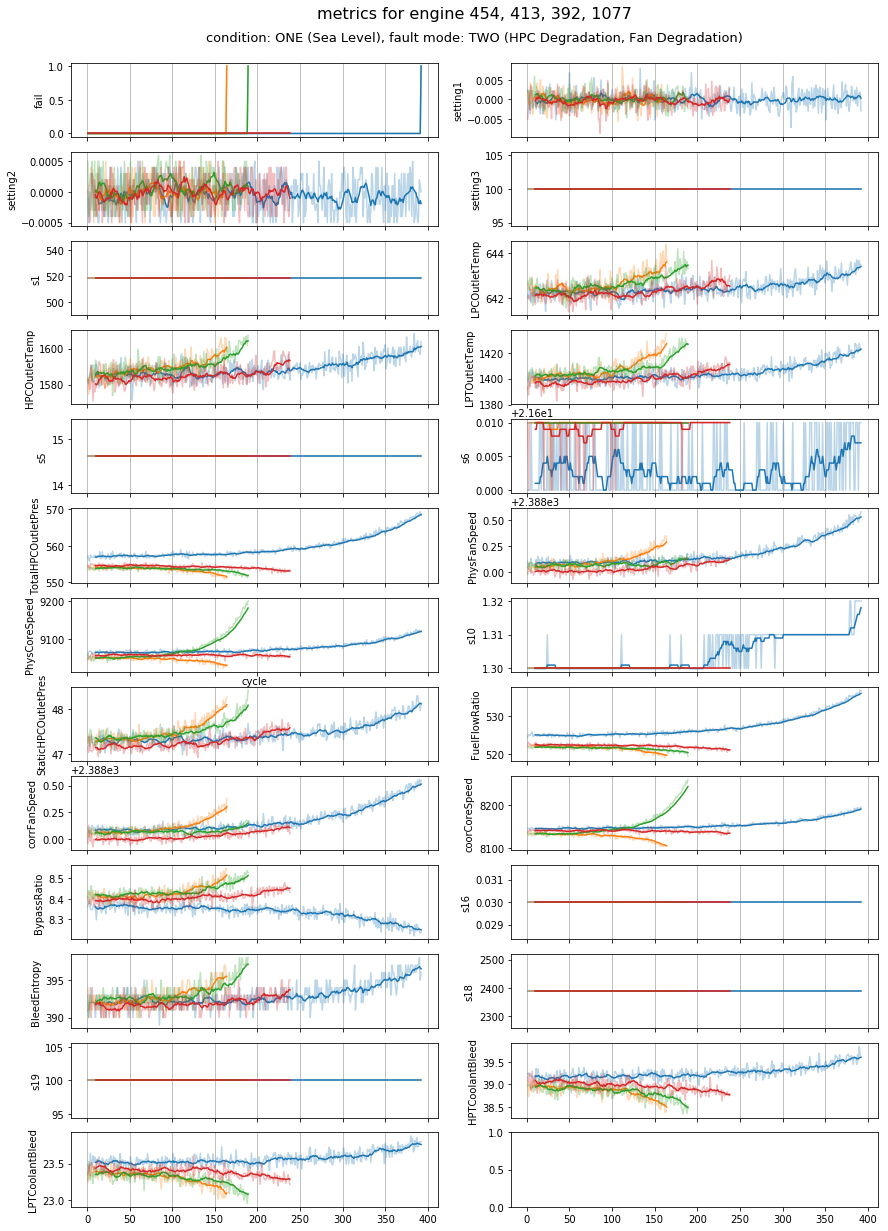

In [6]:
# user parameters
nbEngines = 4
conditions = 'ONE (Sea Level)'
# conditions = 'SIX'
# fault_modes = 'ONE (HPC Degradation)'
fault_modes = 'TWO (HPC Degradation, Fan Degradation)'
columnToPLot = [
    'fail',
    'setting1','setting2','setting3',
    's1','LPCOutletTemp','HPCOutletTemp','LPTOutletTemp','s5','s6',
    'TotalHPCOutletPres','PhysFanSpeed','PhysCoreSpeed','s10',
    'StaticHPCOutletPres','FuelFlowRatio','corrFanSpeed','coorCoreSpeed',
    'BypassRatio','s16','BleedEntropy','s18','s19','HPTCoolantBleed',
    'LPTCoolantBleed'
]
movingAvgWindow = 10
nCols = 2

def plotTimeSeries(nbEngines,conditions,fault_modes,movingAvgWindow=10,nCols=2):
    # auto parameters
    nRows = int(np.ceil(len(columnToPLot)/nCols))
    mask = (dset['conditions']==conditions) & (dset['fault_modes']==fault_modes)
    engineIds = dset.loc[mask,'id'].sample(n=nbEngines).values

    # plot
    fig,axs = plt.subplots(nrows=nRows,ncols=nCols,sharex=True,figsize=[14,1.5*nRows])

    for engId in engineIds:
        mask = dset['id']==engId
        dat = dset.loc[mask].sort_values(by='cycle')
        xs = dat['cycle']
        for i,(ax,col) in enumerate(zip(axs.reshape(-1),columnToPLot)):
            ys = dat[col]
            p = ax.plot(xs,ys,alpha=0.3)
            color = p[0].get_color()
            ys_rolAvg = dat[col].rolling(window=movingAvgWindow).mean()
            if col=='fail':
                ys_rolAvg = dat[col]
            ax.plot(xs,ys_rolAvg,color=color)
            ax.grid(True,axis='x')
            ax.set_ylabel(col)
            if i==nRows-1:
                ax.set_xlabel('cycle')

    fig.suptitle(
        t='metrics for engine {}'.format(', '.join([str(i) for i in engineIds])),
        fontsize=16
    )
    fig.text(
        x=0.5,
        y=0.955,
        s='condition: {}, fault mode: {}'.format(conditions,fault_modes),
        horizontalalignment='center',
        fontsize=13
    )
    plt.subplots_adjust(left=0.1,top=0.94)
    
plotTimeSeries(nbEngines,conditions,fault_modes)

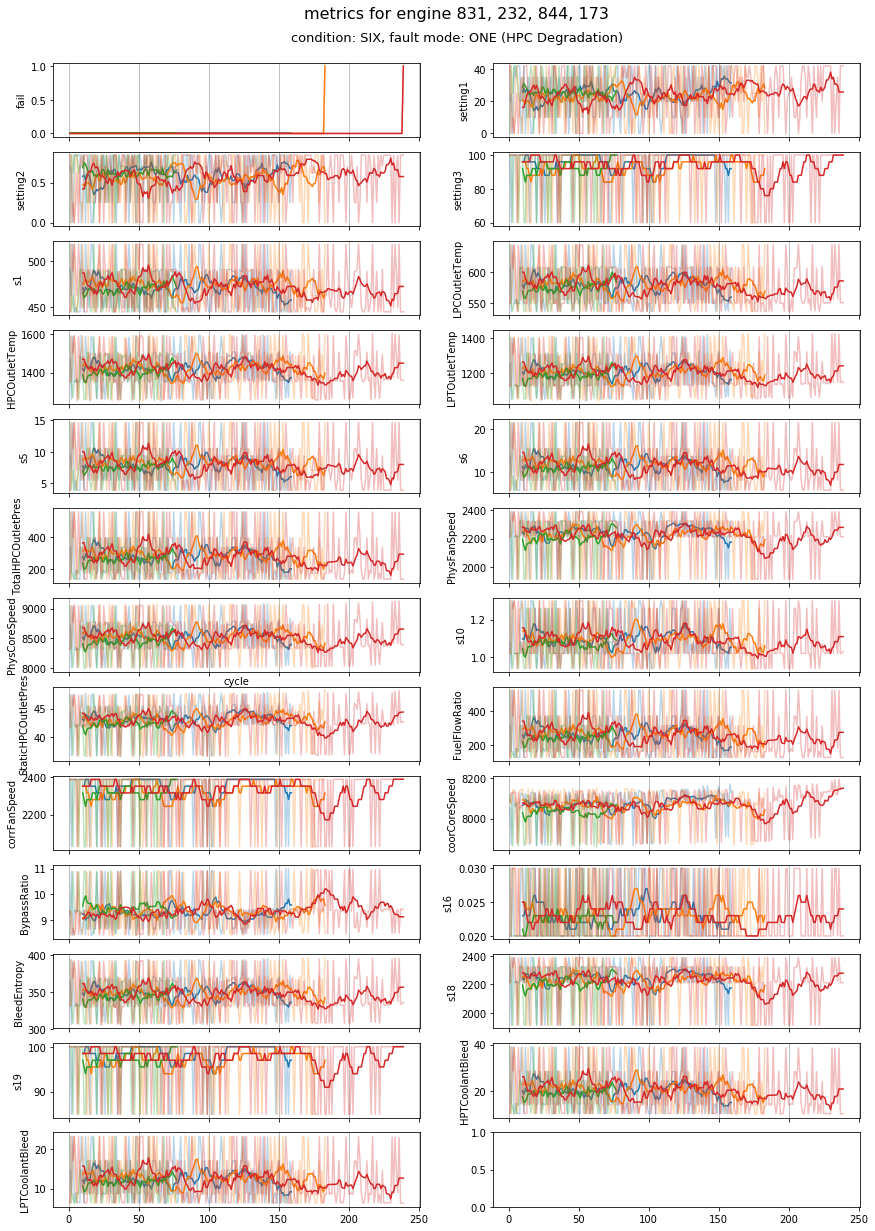

In [7]:
# conditions = 'ONE (Sea Level)'
conditions = 'SIX'
fault_modes = 'ONE (HPC Degradation)'
# fault_modes = 'TWO (HPC Degradation, Fan Degradation)'
plotTimeSeries(nbEngines,conditions,fault_modes)

In [8]:
def plotCrossCoor(df,figsize=[10,10],nanThreshold=None):
    '''
    Function plots the cross-correlation matrix for each column pair in a 
    dataframe (df). 

    Arguments
    ---------
    df: pandas DataFrame
    figsize: list of two positive numerics
        Size of the figure
    nanThreshold: float between 0 and 1. Default=None
        if the cross-correlation c>nanThreshold or c<-nanThreshold, c is set to 
        np.nan. The idea is to flag high correlation and anti-correlation. If 
        nanThreshold=None, no threshold applied.
    '''
    fig, ax = plt.subplots(figsize=figsize)
    
    corr = df.corr()
    corr[np.triu(np.ones_like(corr),k=1)==1] = np.nan
    if nanThreshold!=None:
        corr[corr>abs(nanThreshold)] = np.nan
        corr[corr<-abs(nanThreshold)] = np.nan
    im = ax.imshow(corr,cmap='RdBu_r')
    plt.colorbar(im)
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns)
    ax.set_yticks(range(len(df.columns)))
    ax.set_yticklabels(df.columns)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Cross-correlation matrix',fontsize=14)
    
    return fig,ax

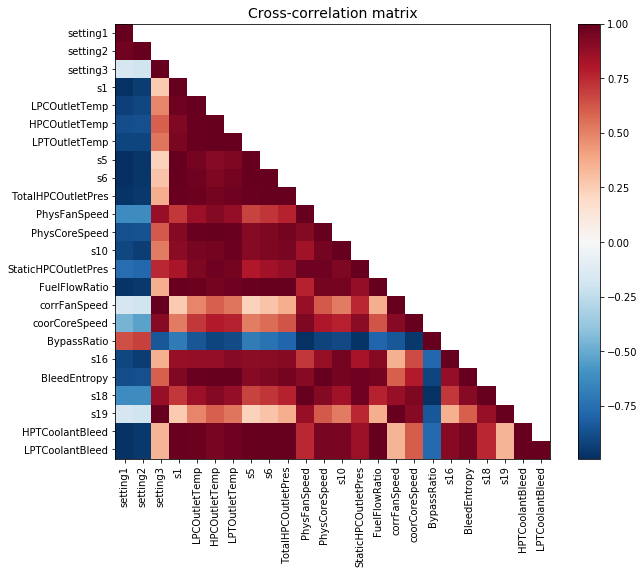

In [9]:
columnToCorr = [
    'setting1','setting2','setting3',
    's1','LPCOutletTemp','HPCOutletTemp','LPTOutletTemp','s5','s6',
    'TotalHPCOutletPres','PhysFanSpeed','PhysCoreSpeed','s10',
    'StaticHPCOutletPres','FuelFlowRatio','corrFanSpeed','coorCoreSpeed',
    'BypassRatio','s16','BleedEntropy','s18','s19','HPTCoolantBleed',
    'LPTCoolantBleed'
]
fig,ax = plotCrossCoor(dset[columnToCorr],figsize=[10,8],nanThreshold=None)

Some sensor values are highly correlated. Let's remove some obvious one:
* LPTCoolantBleed:
* LPCOutletTemp:
* S5 and S6: They are highly correlated to the Tolal high pressure compressor outlet pressure (TotalHPCOutletPres). I suspect that these sensor are Total pressure measure at the LPC and LTP outlet.

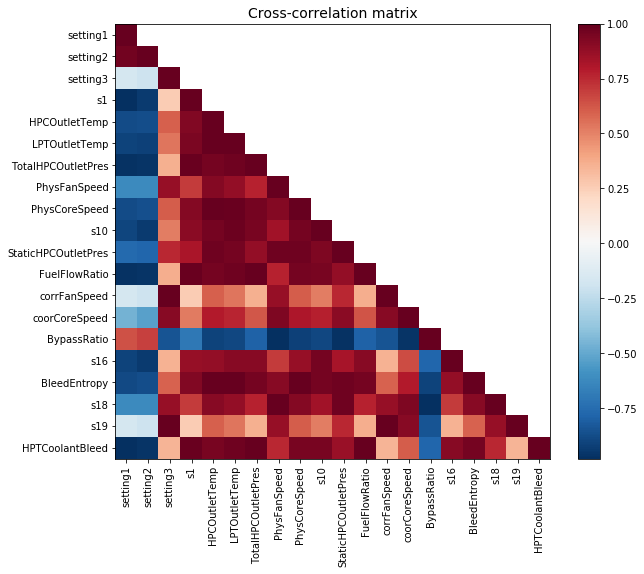

In [10]:
columnToCorr = [
    'setting1','setting2','setting3',
    's1',
#     'LPCOutletTemp',
    'HPCOutletTemp',
    'LPTOutletTemp',
#     's5',
#     's6',
    'TotalHPCOutletPres',
    'PhysFanSpeed','PhysCoreSpeed',
    's10',
    'StaticHPCOutletPres','FuelFlowRatio','corrFanSpeed','coorCoreSpeed',
    'BypassRatio','s16','BleedEntropy','s18','s19',
    'HPTCoolantBleed',
#     'LPTCoolantBleed'
]
fig,ax = plotCrossCoor(dset[columnToCorr],figsize=[10,8],nanThreshold=None)

In [11]:
df = dset.loc[dset['fail']==1,['fail','cycle']].sort_values('cycle')

fig = plt.figure()

<Figure size 432x288 with 0 Axes>

# Train models

## SageMaker linear-learner with lagged values

In [12]:
import io
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer

In [13]:
# where the model and the datasets used for training and validation will be 
# stored
bucket = 'vonlanth-development'

# role used. One can also get the role with
#     role = sama.get_execution_role()
# if within a managed SageMaker notebook.
role = 'arn:aws:iam::483198303350:role/service-role/AmazonSageMaker-ExecutionRole-20191119T172940'

### prepare dataset

In [14]:
# select the sensors used as features (i.e. the X's)
sensorFeatures = [
    'setting1','setting2','setting3',
    's1',
#     'LPCOutletTemp',
    'HPCOutletTemp',
    'LPTOutletTemp',
#     's5',
#     's6',
    'TotalHPCOutletPres',
    'PhysFanSpeed','PhysCoreSpeed',
    's10',
    'StaticHPCOutletPres','FuelFlowRatio','corrFanSpeed','coorCoreSpeed',
    'BypassRatio','s16','BleedEntropy','s18','s19',
    'HPTCoolantBleed',
#     'LPTCoolantBleed'
]

# variable to predict (i.e. the y)
varToPred = ['RUL']

# add n lagged values for each sensor features. We also create a list with all 
# the lagged sensor features.
laggedSensorFeatures = list()
dset = dset.sort_values(['id','cycle']).reset_index(drop=True)
nLagged = 3
#- add the column where the lagged values will be stored
for sen in sensorFeatures:
    for lag in range(1,nLagged+1):
        lagCol = '{}_lag{}'.format(sen,lag)
        laggedSensorFeatures.append(lagCol)
        dset[lagCol] = np.nan
#- computed the laggd values
ids = np.sort(dset['id'].unique())
for i,engId in enumerate(ids):
    nPrint = 50
    if i%nPrint==0:
        print('working with IDs from {} to {} (total: {})'.format(i+1,i+nPrint+1,len(ids)))
    currentIdx = dset.loc[dset['id']==engId].index
    for sen in sensorFeatures:
        for lag in range(1,nLagged+1):
            lagCol = '{}_lag{}'.format(sen,lag)
            dset.loc[currentIdx,lagCol] = dset.loc[currentIdx][sen].shift(lag)

working with IDs from 1 to 51 (total: 1416)
working with IDs from 51 to 101 (total: 1416)
working with IDs from 101 to 151 (total: 1416)
working with IDs from 151 to 201 (total: 1416)
working with IDs from 201 to 251 (total: 1416)
working with IDs from 251 to 301 (total: 1416)
working with IDs from 301 to 351 (total: 1416)
working with IDs from 351 to 401 (total: 1416)
working with IDs from 401 to 451 (total: 1416)
working with IDs from 451 to 501 (total: 1416)
working with IDs from 501 to 551 (total: 1416)
working with IDs from 551 to 601 (total: 1416)
working with IDs from 601 to 651 (total: 1416)
working with IDs from 651 to 701 (total: 1416)
working with IDs from 701 to 751 (total: 1416)
working with IDs from 751 to 801 (total: 1416)
working with IDs from 801 to 851 (total: 1416)
working with IDs from 851 to 901 (total: 1416)
working with IDs from 901 to 951 (total: 1416)
working with IDs from 951 to 1001 (total: 1416)
working with IDs from 1001 to 1051 (total: 1416)
working with I

In [15]:
# check the dataset
mask = dset['id']==456
dset.loc[mask,['id','cycle','HPCOutletTemp','HPCOutletTemp_lag1','HPCOutletTemp_lag2','HPCOutletTemp_lag3']].head(10)

,id,cycle,HPCOutletTemp,HPCOutletTemp_lag1,HPCOutletTemp_lag2,HPCOutletTemp_lag3
97740,456,1,1579.29,NaN,NaN,NaN
97741,456,2,1578.39,1579.29,NaN,NaN
97742,456,3,1580.56,1578.39,1579.29,NaN
97743,456,4,1577.20,1580.56,1578.39,1579.29
97744,456,5,1587.68,1577.20,1580.56,1578.39
97745,456,6,1577.01,1587.68,1577.20,1580.56
97746,456,7,1583.06,1577.01,1587.68,1577.20
97747,456,8,1583.40,1583.06,1577.01,1587.68
97748,456,9,1588.18,1583.40,1583.06,1577.01
97749,456,10,1574.85,1588.18,1583.40,1583.06


In [16]:
# split the dataset: We have about 1500 engines having collectively >250k cycles. 
# Let's split into a training set, a validation set and a test set.
trainRatio = 0.96
valRatio = 0.02

# perform the split
if (trainRatio+valRatio)>=1:
    raise ValueError('The sum trainRatio+valRatio must be smaller than 1')
testRatio = 1-(trainRatio+valRatio)
trainSplitIdx = int(np.floor(len(dset)*trainRatio))
valSplitIdx = int(np.floor(len(dset)*(trainRatio+valRatio)))
dsetTrain = dset.iloc[:trainSplitIdx,:]
dsetVal = dset.iloc[trainSplitIdx:valSplitIdx,:]
dsetTest = dset.iloc[valSplitIdx:,:]


print(
    ('train set: {:.02f}%, shape {},start idx {}, end idx {}'
    ).format(trainRatio*100,dsetTrain.shape,dsetTrain.index[0],dsetTrain.index[-1])
)
print(
    ('train set: {:.02f}%, shape {},start idx {}, end idx {}'
    ).format(valRatio*100,dsetVal.shape,dsetVal.index[0],dsetVal.index[-1])
)
print(
    ('train set: {:.02f}%, shape {},start idx {}, end idx {}'
    ).format(testRatio*100,dsetTest.shape,dsetTest.index[0],dsetTest.index[-1])
)

train set: 96.00%, shape (254645, 92),start idx 0, end idx 254644
train set: 2.00%, shape (5305, 92),start idx 254645, end idx 259949
train set: 2.00%, shape (5306, 92),start idx 259950, end idx 265255


In [19]:
len(dset['id'].unique())

1416

In [17]:
(dsetTrain.isna()).sum().sort_index()

BleedEntropy               0
BleedEntropy_lag1       1348
BleedEntropy_lag2       2696
BleedEntropy_lag3       4044
BypassRatio                0
BypassRatio_lag1        1348
BypassRatio_lag2        2696
BypassRatio_lag3        4044
FuelFlowRatio              0
FuelFlowRatio_lag1      1348
FuelFlowRatio_lag2      2696
FuelFlowRatio_lag3      4044
HPCOutletTemp              0
HPCOutletTemp_lag1      1348
HPCOutletTemp_lag2      2696
HPCOutletTemp_lag3      4044
HPTCoolantBleed            0
HPTCoolantBleed_lag1    1348
HPTCoolantBleed_lag2    2696
HPTCoolantBleed_lag3    4044
LPCOutletTemp              0
LPTCoolantBleed            0
LPTOutletTemp              0
LPTOutletTemp_lag1      1348
LPTOutletTemp_lag2      2696
LPTOutletTemp_lag3      4044
PhysCoreSpeed              0
PhysCoreSpeed_lag1      1348
PhysCoreSpeed_lag2      2696
PhysCoreSpeed_lag3      4044
                        ... 
s16                        0
s16_lag1                1348
s16_lag2                2696
s16_lag3      

In [ ]:
# plit into X and y arrays, then save into s3 bucket in a format understandable 
# by the sagemaker model
xTrain = dsetTrain[sensorFeatures+laggedSensorFeatures]
yTrain = dsetTrain[varToPred]

xVal = dsetVal[sensorFeatures+laggedSensorFeatures]
yVal = dsetVal[varToPred]

xTest = dsetTest[sensorFeatures+laggedSensorFeatures]
yTest = dsetTest[varToPred]

def saveDatasetToS3(X,y,bucket,prefix,key,saveAs):
    '''
    Save a dataset for SageMaker estimator. Currently, can only save as 'bytes'
    '''
    outputBucket = None
    if saveAs=='bytes':
        # create the bytes buffer
        buf = io.BytesIO()
        smac.write_numpy_to_dense_tensor(
            file=buf,
            array=X.astype('float32'),
            labels=y.astype('float32')
        )
        buf.seek(0)
        
        # write to S3
        fileObject = os.path.join(prefix,key)
        boto3.resource('s3').Bucket(bucket).Object(fileObject).upload_fileobj(buf)
        outputBucket = 's3://{}/{}'.format(os.path.join(bucket,fileObject))
    else:
        raise ValueError('unknown "saveAs" mode')
        
    return outputBucket

        
prefix = 'sagemaker/turbofan_linLearn'
s3Train = saveDatasetToS3(xTrain.values,yTrain.values.reshape(-1),bucket,prefix,'trainSet.data','bytes')
print('train set on s3: {}'.format(s3Train))

In [ ]:
yTrain.values.reshape(-1)

### Set up the model

## Recurrent Neural Network (RNN)

# Sandbox